# K-Nearest Neighbor (kNN) 연습

*이 워크시트를 완성하고 제출하세요. (출력물과 워크시트에 포함되지 않은 코드들을 포함해서) 더 자세한 정보는 코스 웹사이트인 [숙제 페이지](http://vision.stanford.edu/teaching/cs231n/assignments.html)에서 볼 수 있습니다.*

kNN 분류기는 다음 두 단계로 구성됩니다.

- 학습중에, 분류기는 데이터를 학습하고 그것을 기억합니다.
- 테스트중에, KNN은 모든 이미지를 훈련된 이미지와 k 번째 레이블을 전송하는 가장 유사한 훈련 예와 비교합니다.
- k의 값은 교차 검증되었습니다.

이번 연습에서 우리는 이러한 단계들을 수행하고 
간단한 이미지 분류기 pipeline, 교차검증을 이해하고, 효율적인 벡터화된 코드를 작성하는 방법을 알아봅니다.

In [2]:
# 이 notebook을 위해 몇가지 설치 코드를 실행하세요.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# matplotlib figure들을 새 창에서 뛰우지 않고 이 notebook에서 하기 위한 약간의 마법입니다.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 이 notebook이 외부 파이썬 모듈을 재호출하기위한 코드입니다.
# 다음 링크를 확인해 보세요. http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# CIFAR-10 데이터를 불러옵니다.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# sanity 체크로서 학습 데이터와 테스트 데이터의 크기를 출력합니다.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


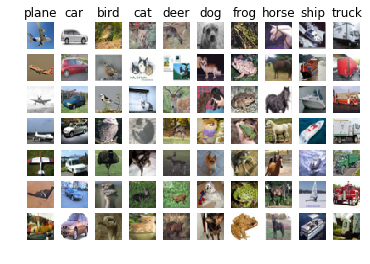

In [4]:
# 데이터셋에서 몇 가지 예제를 시각화 합니다.
# 각 class마다 약간의 학습 이미지를 보여줍니다.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# 이 연습에 더 효율적인 코드 실행을 위한 데이터를 표본
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# 이미지 데이터를 행으로 변형시킵니다.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(5000, 3072) (500, 3072)


In [7]:
from cs231n.classifiers import KNearestNeighbor

# kNN 분류기를 생성합니다.
# kNN분류기를 학습시킬때 분류기는 단순히 데이터를 기억하고
# 더 이상의 처리를 하지 않는다는것을 기억하세요.
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

이제 테스트데이터를 kNN 분류기로 분류해볼껍니다.
이 과정을 두 단계로 분류할 수 있습니다:

1. 먼저 모든 테스트 예제와 모든 훈련 예제 사이의 거리를 계산해야 합니다.
2. Given these distances, for each test example 
we find the k nearest examples and have them vote 
for the label

모든 테스트 예제와 학습 예제 사이의 거리 행렬을 계산하는 것 부터 시작해 봅시다. **Ntr** 학습 예제와 **Nte** 테스트 예제가 있을 때, 각 (i, j) 요소가 i번째 테스트와 j번째 훈련 예제의 거리를 나타내는 **Nte x Ntr** 행렬을 결과로 얻을 수 있습니다.


먼저 `cs231n/classifiers/k_nearest_neighbor.py`를 열고 각 (테스트, 학습) 예제를 계산하는데 (매우 비효율적인) 이중 반복문을 사용한  `compute_distances_two_loops`를 구현해 보세요.

In [8]:
# cs231n/classifiers/k_nearest_neighbor.py를 열고
# compute_distances_two_loops를 구현해 보세요.

# 구현을 테스트해보세요.
dists = classifier.compute_distances_two_loops(X_test)
print dists.shape

('num_test ', 500)
('num_train ', 5000)
('x[0],', array([158., 112.,  49., ...,  21.,  67., 110.]))
('self.X_train[0]', array([ 59.,  62.,  63., ..., 123.,  92.,  72.]), 3072, (3072,))
0.0
3803.92350080808
(500, 5000)


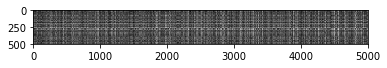

In [9]:
# 거리 행렬을 시각화 할 수 있습니다: 각 행은 하나의 시험 예제와 훈련 예제의 거리
plt.imshow(dists, interpolation='none')
plt.show()

**연습문제 #1** 일부 행, 열이 더 밝게 가시화 된 거리 행렬의 구조화된 패턴에 주목하세요. (기본 색상에서 검은 색은 낮은 간격을 나타내는 반면, 흰색은 높은 간격을 나타내는 것에 주목하세요.)

- 뚜렷하게 밝은 행의 데이터가 그렇게 표시된 원인은 무엇일까요?
- 열은 어떤 원인 때문에 저럴까요?

**당신의 답**: *여기에 쓰세요*



In [10]:
# 이제 predict_labels를 구현해보고 아래의 코드를 실행해 보세요.
# k = 1 을 사용합니다.(가장 가까운 이웃으로)
y_test_pred = classifier.predict_labels(dists, k=1)

# 예측 예제의 정확도를 계산하고 출력하세요.
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


우리는 대략 `27%`정도의 정확도를 예상합니다. 이제 `k = 5`같은 좀더 큰 `k`에 대해서도 실행해 보세요.

In [11]:
y_test_pred = classifier.predict_labels(dists, k=5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 139 / 500 correct => accuracy: 0.278000


`k = 1`보다 약간 더 좋은 성능을 기대할 수 있습니다.

In [18]:
# 이제 부분 벡터화와 단일 반복문을 사용하여 거리 행렬의 계산 속도를 높일 수 있습니다.
# compute_distance_one_loop를 구현해보고 아래의 코드를 실행해 보세요.
dists_one = classifier.compute_distances_one_loop(X_test)

# 우리의 벡터화 구현이 맞다는것을 보장하기 위해, 
# 우리는 navie한 구현을 확인해야 합니다.
# 두 행렬의 유사 여부를 결정하는 방법은 여러가지가 있습니다.
# 단순한 방법은 Frobenius norm입니다.
# 이 Frobenius norm의 두 행렬은 모든 원소의 차이의 제곱합의 제곱근 입니다.
# 다른 말로 하면, 행렬을 벡터로 변형하고 유클리드 거리를 계산합니다.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

((3072,), (5000, 3072))
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)
(5000,)


In [35]:
# 이제 compute_distances_no_loops 안의 완전히 벡터화된 버전을 구현하고 실행합니다.
dists_two = classifier.compute_distances_no_loops(X_test)

# 거리 행렬이 우리가 전에 계산한 것과 일치하는지 확인합니다.
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

(5000, 3072)
((500, 5000), (5000,), (500, 1))
Difference was: 0.000000
Good! The distance matrices are the same


In [36]:
# 구현한 것들이 얼마나 빠른지 비교합시다.
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# 완전 벡터화 구현이 훨씬 더 빠른 성능을 낸다는것을 볼 수 있습니다.

('num_test ', 500)
('num_train ', 5000)
('x[0],', array([158., 112.,  49., ...,  21.,  67., 110.]))
('self.X_train[0]', array([ 59.,  62.,  63., ..., 123.,  92.,  72.]), 3072, (3072,))
0.0
3803.92350080808
Two loop version took 32.498999 seconds
((3072,), (5000, 3072))
One loop version took 27.044527 seconds
(5000, 3072)
((500, 5000), (5000,), (500, 1))
No loop version took 0.584798 seconds


### 교차검증

우리는 k-Nearest Neighbor 분류기를 구현했지만 임의로 k = 5라는 값을 정했습니다. 이제 hyperparameter의 교차검증으로 최선의 값을 결정할 것입니다.

In [81]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
####################################################################################
# TODO:                                                                            #
# 폴더에 훈련 데이터를 분류합니다.                                                 #
# 분류 후에, X_train_folds 와 y_train_folds는 y_train_folds[i]가                   #
# X_train_folds[i]의 점에 대한 레이블 벡터인 num_folds의 길이의 목록이어야 합니다. #
# 힌트: numpy의 array_split 함수를 살펴보세요.                                     #
####################################################################################

#X_train_folds = np.array_split(X_train, num_folds)
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))
print(y_train_folds.shape)

################################################################################
#                                    코드의 끝                                #
################################################################################

# 사전은 서로 다른 교차 검증을 실행할 때 찾은 k의 값에 대한 정확도를 가지고 있습니다.
# k_to_accuracies[k]는 'num_folds' 길이의 리스트로 
# 각기 다른 k 값을 사용할 때의 정확도를 담고있습니다.
k_to_accuracies = {}


####################################################################################
# TODO:                                                                            #
# 최고의 k 값을 찾기 위해 k-fold 교차 검증을 수행합니다.                           #
# 가능한 각 k에 대해서, k-nearest-neighbor 알고리즘을 numpy의num_folds회 실행합니다.#
# 각각의 경우에 모두 사용하되 그 중 하나는 훈련 데이터로,                          #
# 마지막 하나는 검증 데이터로 사용합니다.                                          #
####################################################################################

for k in k_choices:
    k_to_accuracies[k] = []
    for n in xrange(num_folds):
        
        X_tr = np.array([])
        Y_tr = np.array([])
        for i in range(num_folds):
            if i != n:
                if len(X_tr) == 0:
                    X_tr = X_train_folds[i].reshape(1000,3072)
                    Y_tr = y_train_folds[i].reshape(1000)
                else:
                    X_tr = np.concatenate((X_tr, X_train_folds[i].reshape(1000,3072)))
                    Y_tr = np.concatenate((Y_tr, y_train_folds[i].reshape(1000)))
        X_ts = X_train_folds[n]
        Y_ts = y_train_folds[n]

        cls = KNearestNeighbor()
        cls.train(X_tr, Y_tr)
 
        pred = cls.predict_labels(X_ts, k)
        
        num_correct = np.sum(pred == Y_ts)
        acc = float(num_correct) / num_test      
        k_to_accuracies[k].append(acc)

################################################################################
#                                    코드의 끝                                 #
################################################################################

# 계산된 정확도를 출력합니다.
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)
    print('')

(5, 1000)
k = 1, accuracy = 0.220000
k = 1, accuracy = 0.162000
k = 1, accuracy = 0.194000
k = 1, accuracy = 0.206000
k = 1, accuracy = 0.232000

k = 3, accuracy = 0.204000
k = 3, accuracy = 0.180000
k = 3, accuracy = 0.200000
k = 3, accuracy = 0.206000
k = 3, accuracy = 0.190000

k = 5, accuracy = 0.202000
k = 5, accuracy = 0.170000
k = 5, accuracy = 0.184000
k = 5, accuracy = 0.188000
k = 5, accuracy = 0.182000

k = 8, accuracy = 0.186000
k = 8, accuracy = 0.210000
k = 8, accuracy = 0.186000
k = 8, accuracy = 0.182000
k = 8, accuracy = 0.190000

k = 10, accuracy = 0.178000
k = 10, accuracy = 0.220000
k = 10, accuracy = 0.218000
k = 10, accuracy = 0.202000
k = 10, accuracy = 0.200000

k = 12, accuracy = 0.196000
k = 12, accuracy = 0.182000
k = 12, accuracy = 0.204000
k = 12, accuracy = 0.204000
k = 12, accuracy = 0.206000

k = 15, accuracy = 0.192000
k = 15, accuracy = 0.168000
k = 15, accuracy = 0.196000
k = 15, accuracy = 0.188000
k = 15, accuracy = 0.222000

k = 20, accuracy = 0.19

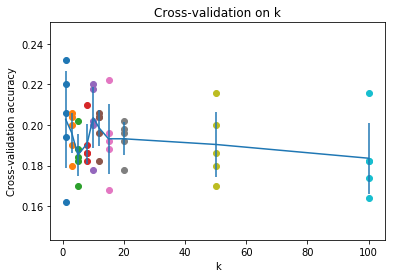

In [82]:
# 원시 관측 플롯
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# 표준편차에 해당하는 오차 막대와 추세선을 그립니다.
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [83]:
# 위의 교차검증 결과에 기반해서 최적의 k를 선택하고 모든 학습 데이터를 
# 이용하여 분류기를 재학습 시키고 테스트 데이터를 이용해 테스트 해봅니다.
# 테스트데이터에 대해서 28%이상의 정확도를 얻을 수 있어야 합니다.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# 정확도를 계산하고 출력합니다.
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

(5000, 3072)
((500, 5000), (5000,), (500, 1))
Got 137 / 500 correct => accuracy: 0.274000
